In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def preprocess_gdm_data(file_path):
    """Preprocess GDM dataset."""
    data = pd.read_excel(file_path, sheet_name='V2.0.1', header=1)

    # Define feature types
    categorical_features = ['GlucoseToleranceTest', 'Obese?']
    numerical_features = [
        'Body Mass Index at Booking', 'AgeAtStartOfSpell',
        'Parity', 'No_Of_previous_Csections',
        'WeightMeasured', 'Gestation at booking (Weeks)',
        'Glucoselevel0minblood', 'Glucoselevel120minblood'
    ]

    selected_features = categorical_features + numerical_features + ['Gestational Diabetes']
    data = data[selected_features]

    # Handle target variable
    data = data.dropna(subset=['Gestational Diabetes'])
    data['Gestational Diabetes'] = data['Gestational Diabetes'].map({'Yes': 1, 'No': 0})

    # Clean non-numeric values in numerical columns
    for col in numerical_features:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert invalid values to NaN

    # Handle categorical features
    categorical_mappings = {
        'GlucoseToleranceTest': {
            'Offered and accepted': 1, 'Offered and declined': 0, 'Not offered': -1
        },
        'Obese?': {'Yes': 1, 'No': 0}
    }
    for col in categorical_features:
        data[col] = data[col].fillna('Unknown')
        data[col] = data[col].map(categorical_mappings.get(col, {}))
        data[col] = data[col].fillna(-1)

    # Handle missing numerical values
    imputer = SimpleImputer(strategy='mean')  # Fill missing values with the mean
    data[numerical_features] = imputer.fit_transform(data[numerical_features])

    # Standardize numerical features
    scaler = StandardScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    X = data.drop('Gestational Diabetes', axis=1).values
    y = data['Gestational Diabetes'].values

    print("Preprocessing Summary:")
    print(f"Numerical features (scaled): {numerical_features}")
    print(f"Categorical features (encoded): {categorical_features}")
    print(f"Number of samples: {len(data)}")
    print("\nClass distribution:")
    print(pd.Series(y).value_counts(normalize=True))  # Convert y to pandas Series for value_counts

    return X, y

if __name__ == "__main__":
    file_path = '/content/GDM Dataset (1).xlsx'
    X, y = preprocess_gdm_data(file_path)

    # Combine processed features and target for export
    processed_data = pd.DataFrame(X, columns=[
        'GlucoseToleranceTest', 'Obese?', 'Body Mass Index at Booking',
        'AgeAtStartOfSpell', 'Parity', 'No_Of_previous_Csections',
        'WeightMeasured', 'Gestation at booking (Weeks)',
        'Glucoselevel0minblood', 'Glucoselevel120minblood'
    ])
    processed_data['target'] = y

    processed_data.to_csv('preprocessed_gdm_dataset.csv', index=False)
    print("\nPreprocessed dataset saved as 'preprocessed_gdm_dataset.csv'.")


Preprocessing Summary:
Numerical features (scaled): ['Body Mass Index at Booking', 'AgeAtStartOfSpell', 'Parity', 'No_Of_previous_Csections', 'WeightMeasured', 'Gestation at booking (Weeks)', 'Glucoselevel0minblood', 'Glucoselevel120minblood']
Categorical features (encoded): ['GlucoseToleranceTest', 'Obese?']
Number of samples: 23490

Class distribution:
0    0.921073
1    0.078927
Name: proportion, dtype: float64

Preprocessed dataset saved as 'preprocessed_gdm_dataset.csv'.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

class GDMDataEnhancer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()

    def reshape_for_cnn(self, X):
        n_samples, n_features = X.shape
        return np.array(X).reshape(n_samples, 1, n_features)

    def enhance_data(self, X, y):
        """Enhance data using SMOTE and prepare for deep learning"""
        # First scale the features
        X_scaled = self.scaler.fit_transform(X)

        # Apply SMOTE to oversample minority class
        smote = SMOTE(random_state=self.random_state)
        X_smote, y_smote = smote.fit_resample(X_scaled, y)

        # Apply undersampling to balance classes
        undersampler = RandomUnderSampler(random_state=self.random_state)
        X_balanced, y_balanced = undersampler.fit_resample(X_smote, y_smote)

        # Reshape for CNN
        X_cnn = self.reshape_for_cnn(X_balanced)

        # Convert to float32
        X_cnn = X_cnn.astype('float32')
        y_balanced = y_balanced.astype('float32')

        return X_cnn, y_balanced

    def add_noise(self, X, noise_factor=0.05):
        noise = np.random.normal(0, noise_factor, X.shape)
        return X + noise

    def create_sequences(self, X, y, sequence_length=3):
        sequences = []
        labels = []

        for i in range(len(X) - sequence_length + 1):
            sequences.append(X[i:i+sequence_length])
            labels.append(y[i+sequence_length-1])

        return np.array(sequences), np.array(labels)

# Example usage:
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('preprocessed_gdm_dataset.csv')

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Print initial class distribution
    print("\nInitial class distribution:")
    print(pd.Series(y).value_counts())

    try:
        # Initialize enhancer
        enhancer = GDMDataEnhancer()

        # Enhance data
        X_enhanced, y_enhanced = enhancer.enhance_data(X, y)

        # Create sequences
        X_sequences, y_sequences = enhancer.create_sequences(X_enhanced, y_enhanced)

        # Print results
        print("\nAfter enhancement:")
        print("Enhanced class distribution:", np.bincount(y_enhanced.astype(int)))
        print("Enhanced data shape for CNN:", X_enhanced.shape)
        print("Sequence data shape for RNN:", X_sequences.shape)

        # Verify data types
        print("\nData types:")
        print("X_enhanced dtype:", X_enhanced.dtype)
        print("y_enhanced dtype:", y_enhanced.dtype)

    except Exception as e:
        print(f"\nError during enhancement: {str(e)}")
        print("\nDataset info:")
        print(X.info())



Initial class distribution:
target
0    21636
1     1854
Name: count, dtype: int64

After enhancement:
Enhanced class distribution: [21636 21636]
Enhanced data shape for CNN: (43272, 1, 10)
Sequence data shape for RNN: (43270, 3, 1, 10)

Data types:
X_enhanced dtype: float32
y_enhanced dtype: float32


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-6-54e0f2cbde36>:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(feature, (sig_df['Correlation'][i], significance[i]))


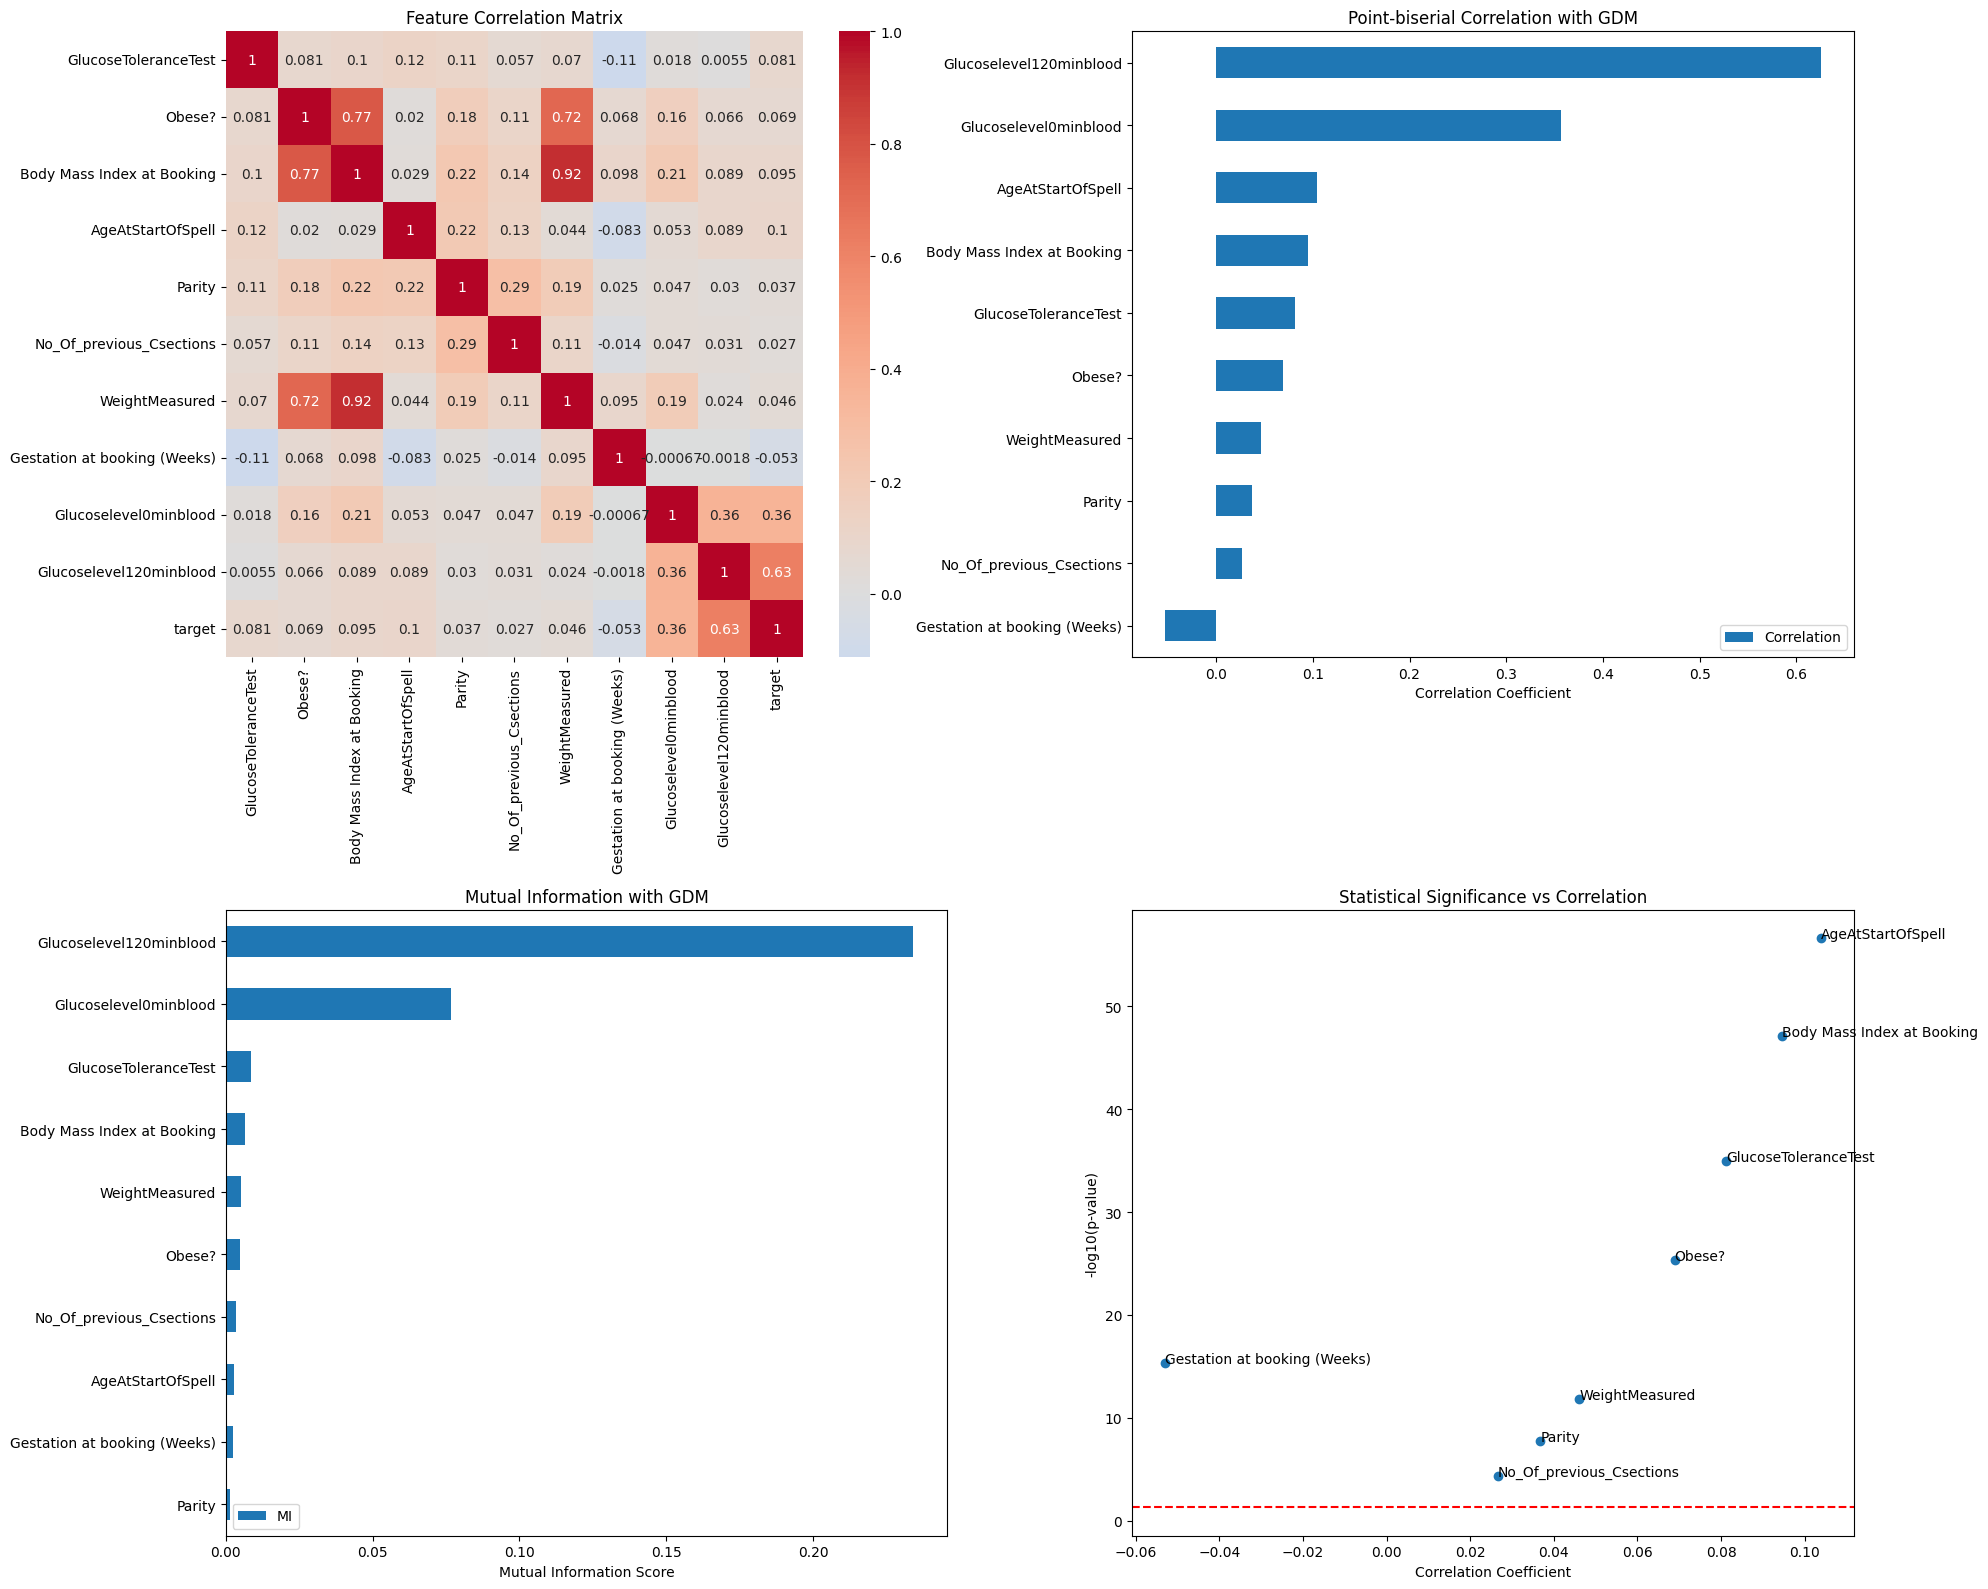


Feature Importance Summary:
                              Correlation       P-value  Mutual_Info
Glucoselevel120minblood          0.625303  0.000000e+00     0.233976
Glucoselevel0minblood            0.356954  0.000000e+00     0.076720
GlucoseToleranceTest             0.081260  1.031211e-35     0.008733
Body Mass Index at Booking       0.094612  7.534039e-48     0.006506
WeightMeasured                   0.046073  1.609572e-12     0.005294
Obese?                           0.068892  4.077589e-26     0.004985
No_Of_previous_Csections         0.026654  4.396936e-05     0.003472
AgeAtStartOfSpell                0.103844  2.512557e-57     0.002790
Gestation at booking (Weeks)    -0.053017  4.261424e-16     0.002517
Parity                           0.036790  1.698313e-08     0.001591


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pointbiserialr
from sklearn.feature_selection import mutual_info_classif

def analyze_feature_correlations(data, target_col='target'):
    """Comprehensive feature correlation analysis with GDM"""

    # Point-biserial correlation for numeric features with binary target
    correlations = {}
    p_values = {}
    mutual_info = {}

    features = data.drop(target_col, axis=1).columns
    for feature in features:
        corr, p_val = pointbiserialr(data[target_col], data[feature])
        correlations[feature] = corr
        p_values[feature] = p_val

    # Calculate mutual information
    X = data.drop(target_col, axis=1)
    mutual_info_scores = mutual_info_classif(X, data[target_col])
    mutual_info = dict(zip(features, mutual_info_scores))

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Correlation Heatmap
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
    axes[0,0].set_title('Feature Correlation Matrix')

    # 2. Point-biserial correlation with GDM
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
    corr_df = corr_df.sort_values('Correlation', ascending=True)

    corr_df.plot(kind='barh', ax=axes[0,1])
    axes[0,1].set_title('Point-biserial Correlation with GDM')
    axes[0,1].set_xlabel('Correlation Coefficient')

    # 3. Mutual Information with GDM
    mi_df = pd.DataFrame.from_dict(mutual_info, orient='index', columns=['MI'])
    mi_df = mi_df.sort_values('MI', ascending=True)

    mi_df.plot(kind='barh', ax=axes[1,0])
    axes[1,0].set_title('Mutual Information with GDM')
    axes[1,0].set_xlabel('Mutual Information Score')

    # 4. Statistical Significance
    sig_df = pd.DataFrame({
        'Correlation': correlations,
        'P-value': p_values,
        'Mutual Info': mutual_info
    }).sort_values('Correlation', ascending=False)

    # Create significance visualization
    significance = -np.log10(sig_df['P-value'])
    plt.sca(axes[1,1])
    plt.scatter(sig_df['Correlation'], significance)
    plt.axhline(-np.log10(0.05), color='r', linestyle='--', label='p=0.05 threshold')

    for i, feature in enumerate(sig_df.index):
        plt.annotate(feature, (sig_df['Correlation'][i], significance[i]))

    axes[1,1].set_title('Statistical Significance vs Correlation')
    axes[1,1].set_xlabel('Correlation Coefficient')
    axes[1,1].set_ylabel('-log10(p-value)')

    plt.tight_layout()
    plt.show()

    # Print detailed summary
    print("\nFeature Importance Summary:")
    summary_df = pd.DataFrame({
        'Correlation': correlations,
        'P-value': p_values,
        'Mutual_Info': mutual_info
    })
    summary_df = summary_df.sort_values('Mutual_Info', ascending=False)
    print(summary_df)

    return summary_df

# Usage
summary = analyze_feature_correlations(data)

In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, GlobalMaxPooling1D, LSTM, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd

def create_non_overlapping_sequences(X, y, sequence_length=2, step_size=1):
    """Create sequences with overlap to preserve more minority class samples"""
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length + 1, step_size):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq, dtype=np.float32)

# Load and preprocess
data = pd.read_csv('preprocessed_gdm_dataset.csv')
X = data.drop('target', axis=1).values
y = data['target'].values

# Scale data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)

# Create sequences with overlap
X_train_seq, y_train_seq = create_non_overlapping_sequences(X_train, y_train, step_size=1)
X_val_seq, y_val_seq = create_non_overlapping_sequences(X_val, y_val, step_size=1)
X_test_seq, y_test_seq = create_non_overlapping_sequences(X_test, y_test, step_size=1)

# Verify class distribution
print("Class distribution after sequence creation:")
print("Train:", np.bincount(y_train_seq.astype(int)))
print("Val:", np.bincount(y_val_seq.astype(int)))
print("Test:", np.bincount(y_test_seq.astype(int)))

# Balance training data
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
smt = SMOTETomek(random_state=42, sampling_strategy={1: int(X_train_flat.shape[0] * 0.4)})
X_train_balanced, y_train_balanced = smt.fit_resample(X_train_flat, y_train_seq)
X_train_balanced = X_train_balanced.reshape(-1, X_train_seq.shape[1], X_train_seq.shape[2])

def create_model(input_shape):
    input_layer = Input(shape=input_shape)

    # CNN branch
    conv1 = Conv1D(32, kernel_size=1, activation="relu", kernel_regularizer=l2(0.01))(input_layer)
    conv2 = Conv1D(32, kernel_size=2, activation="relu", kernel_regularizer=l2(0.01))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv2 = BatchNormalization()(conv2)
    conv1 = GlobalMaxPooling1D()(conv1)
    conv2 = GlobalMaxPooling1D()(conv2)

    # LSTM branch
    lstm = LSTM(48, return_sequences=True, kernel_regularizer=l2(0.01))(input_layer)
    lstm = BatchNormalization()(lstm)
    lstm = LSTM(32, kernel_regularizer=l2(0.01))(lstm)

    combined = Concatenate()([conv1, conv2, lstm])
    combined = BatchNormalization()(combined)
    combined = Dropout(0.4)(combined)

    dense1 = Dense(32, activation="relu", kernel_regularizer=l2(0.01))(combined)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.4)(dense1)

    output = Dense(1, activation="sigmoid")(dense1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0002, weight_decay=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Train model
model = create_model((X_train_seq.shape[1], X_train_seq.shape[2]))

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=6,
        restore_best_weights=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.7,
        patience=3,
        mode='max',
        min_lr=0.00001
    )
]

# Custom class weights based on inverse frequency
class_counts = np.bincount(y_train_seq.astype(int))
class_weight = {0: 1.0, 1: class_counts[0]/class_counts[1] * 1.5}

history = model.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weight,
    callbacks=callbacks
)

# Find optimal threshold using F1 score directly
y_pred_proba_val = model.predict(X_val_seq)
thresholds = np.linspace(0.2, 0.8, 30)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba_val > threshold).astype(int)
    f1 = f1_score(y_val_seq, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]

# Final evaluation
y_pred_proba_test = model.predict(X_test_seq)
y_pred_final = (y_pred_proba_test > best_threshold).astype(int)
print(f"\nOptimal threshold: {best_threshold}")
print("\nTest Set Classification Report:")
print(classification_report(y_test_seq, y_pred_final))

Class distribution after sequence creation:
Train: [15630  1340]
Val: [2758  236]
Test: [3245  278]
Epoch 1/15
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6306 - auc: 0.7557 - loss: 5.0021 - val_accuracy: 0.7084 - val_auc: 0.9872 - val_loss: 2.1289 - learning_rate: 2.0000e-04
Epoch 2/15
701/701 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7643 - auc: 0.9563 - loss: 2.8662 - val_accuracy: 0.8290 - val_auc: 0.9952 - val_loss: 1.7538 - learning_rate: 2.0000e-04
Epoch 3/15
701/701 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8263 - auc: 0.9749 - loss: 2.5050 - val_accuracy: 0.8754 - val_auc: 0.9970 - val_loss: 1.4869 - learning_rate: 2.0000e-04
Epoch 4/15
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8622 - auc: 0.9828 - loss: 2.2031 - val_accuracy: 0.8918 - val_auc: 0.9977 - val_loss: 1.2679 - learning_rate: 2.0000e-04
Epoch 5/15
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8933 - auc: 0.9887 - loss: 1.9593 - val_accuracy: 0.9108 - val_auc: 0.9984 - v

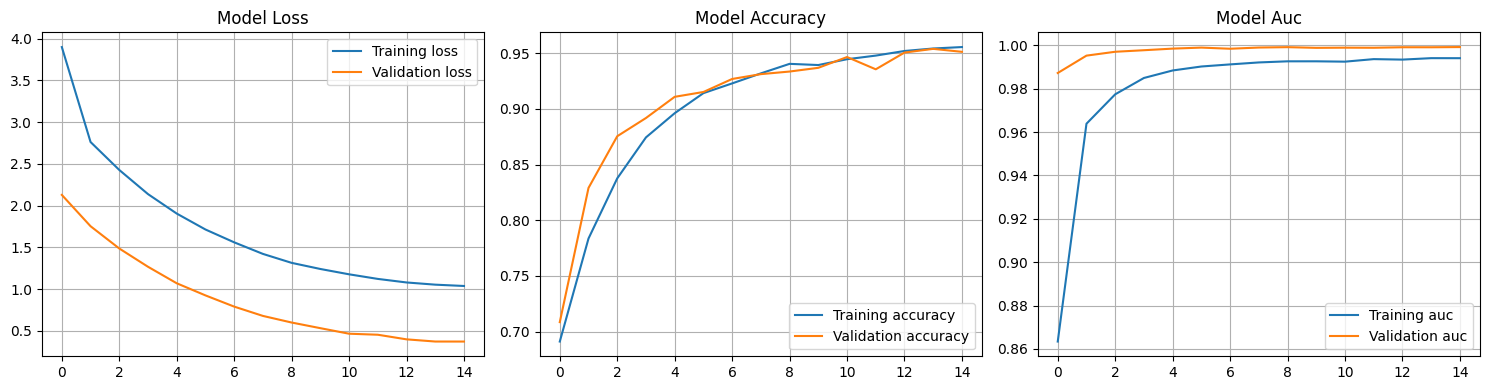

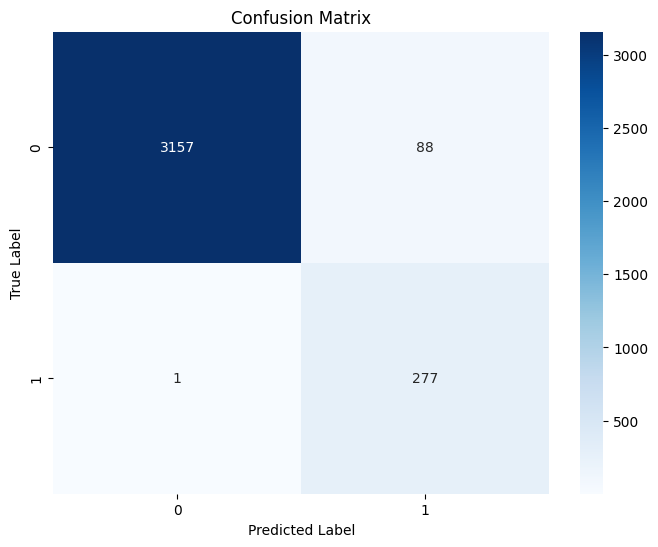

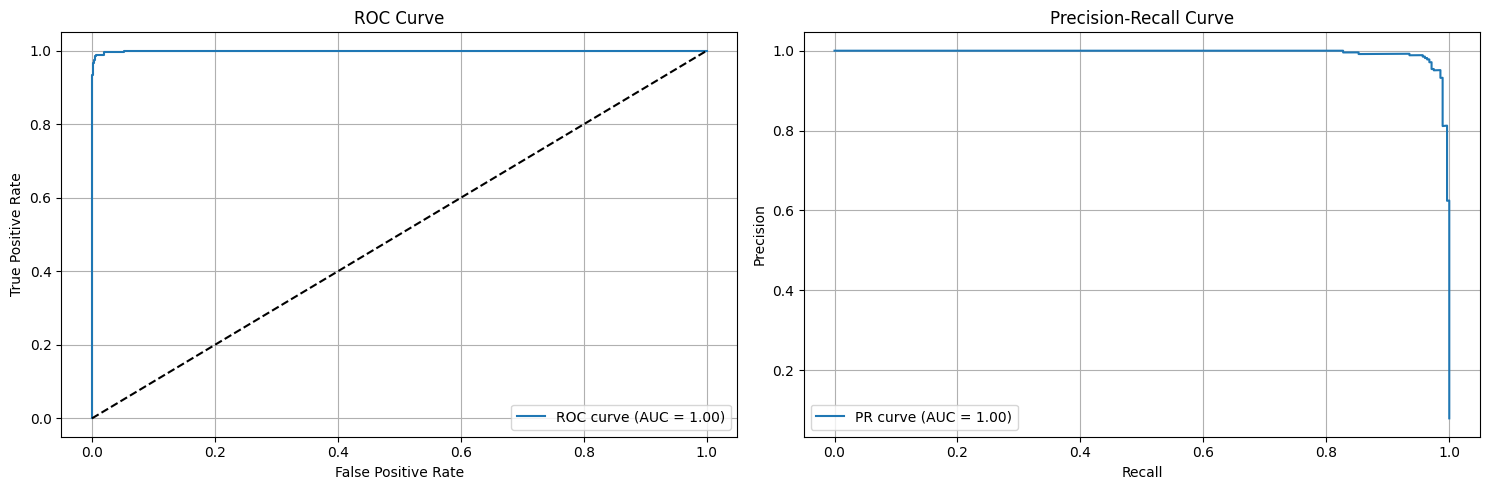

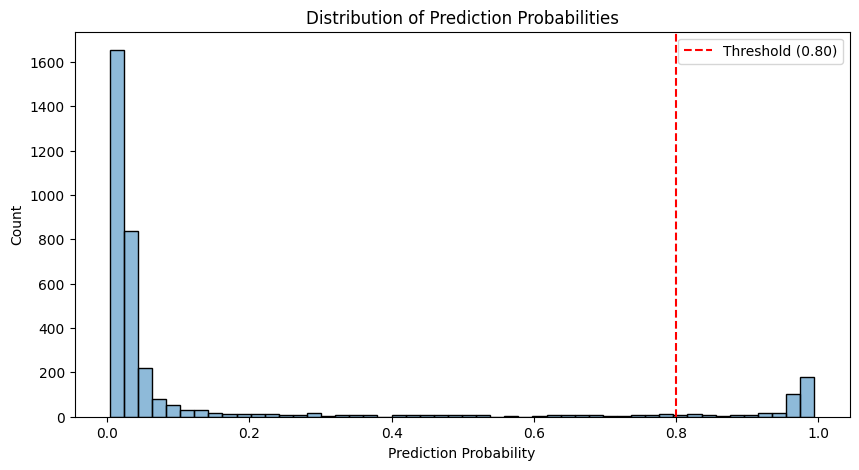

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import numpy as np

def plot_training_metrics(history):
    metrics = ['loss', 'accuracy', 'auc']
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'Model {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_pr_curves(y_true, y_pred_proba):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot ROC
    ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True)

    # Plot Precision-Recall
    ax2.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_proba, threshold):
    plt.figure(figsize=(10, 5))
    sns.histplot(y_pred_proba, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
    plt.title('Distribution of Prediction Probabilities')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Usage
plot_training_metrics(history)
plot_confusion_matrix(y_test_seq, y_pred_final)
plot_roc_pr_curves(y_test_seq, y_pred_proba_test)
plot_prediction_distribution(y_pred_proba_test, best_threshold)




111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Neural Network Results:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      3245
         1.0       0.76      1.00      0.86       278

    accuracy                           0.97      3523
   macro avg       0.88      0.98      0.92      3523
weighted avg       0.98      0.97      0.98      3523

ROC AUC: 0.9995

ELM Results:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      3245
         1.0       0.97      0.33      0.49       278

    accuracy                           0.95      3523
   macro avg       0.96      0.66      0.73      3523
weighted avg       0.95      0.95      0.93      3523

ROC AUC: 0.9681
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


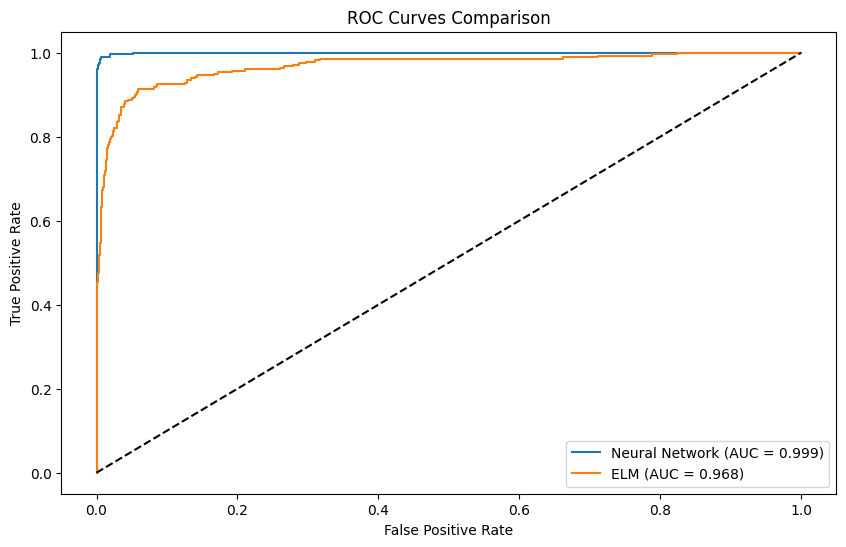

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf

class ELM:
    def __init__(self, n_hidden=100, activation='sigmoid'):
        self.n_hidden = n_hidden
        self.activation = activation
        self.W = None
        self.beta = None
        self.scaler = StandardScaler()

    def _activate(self, X):
        if self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-X))
        elif self.activation == 'relu':
            return np.maximum(X, 0)
        return X

    def fit(self, X, y):
        # Flatten the sequential data
        X_flat = X.reshape(X.shape[0], -1)

        # Scale the input
        X_flat = self.scaler.fit_transform(X_flat)

        # Initialize random weights
        n_samples, n_features = X_flat.shape
        self.W = np.random.normal(size=[n_features, self.n_hidden])

        # Calculate hidden layer output
        H = self._activate(X_flat.dot(self.W))

        # Calculate output weights
        self.beta = np.linalg.pinv(H).dot(y)

        return self

    def predict_proba(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        X_flat = self.scaler.transform(X_flat)
        H = self._activate(X_flat.dot(self.W))
        return H.dot(self.beta)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) > threshold).astype(int)

def compare_models(X_train, X_test, y_train, y_test, nn_model, best_threshold):
    # Train ELM
    elm = ELM(n_hidden=150, activation='sigmoid')
    elm.fit(X_train, y_train)

    # Get predictions from both models
    nn_pred = (nn_model.predict(X_test) > best_threshold).astype(int)
    elm_pred = elm.predict(X_test, threshold=best_threshold)

    # Calculate ROC AUC
    nn_auc = roc_auc_score(y_test, nn_model.predict(X_test))
    elm_auc = roc_auc_score(y_test, elm.predict_proba(X_test))

    print("Neural Network Results:")
    print(classification_report(y_test, nn_pred))
    print(f"ROC AUC: {nn_auc:.4f}")

    print("\nELM Results:")
    print(classification_report(y_test, elm_pred))
    print(f"ROC AUC: {elm_auc:.4f}")

    # Plot ROC curves
    plt.figure(figsize=(10, 6))

    # Neural Network ROC
    fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_model.predict(X_test))
    plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_auc:.3f})')

    # ELM ROC
    fpr_elm, tpr_elm, _ = roc_curve(y_test, elm.predict_proba(X_test))
    plt.plot(fpr_elm, tpr_elm, label=f'ELM (AUC = {elm_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.show()

    return elm

# Compare models
elm_model = compare_models(
    X_train_balanced,
    X_test_seq,
    y_train_balanced,
    y_test_seq,
    model,
    best_threshold
)